# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

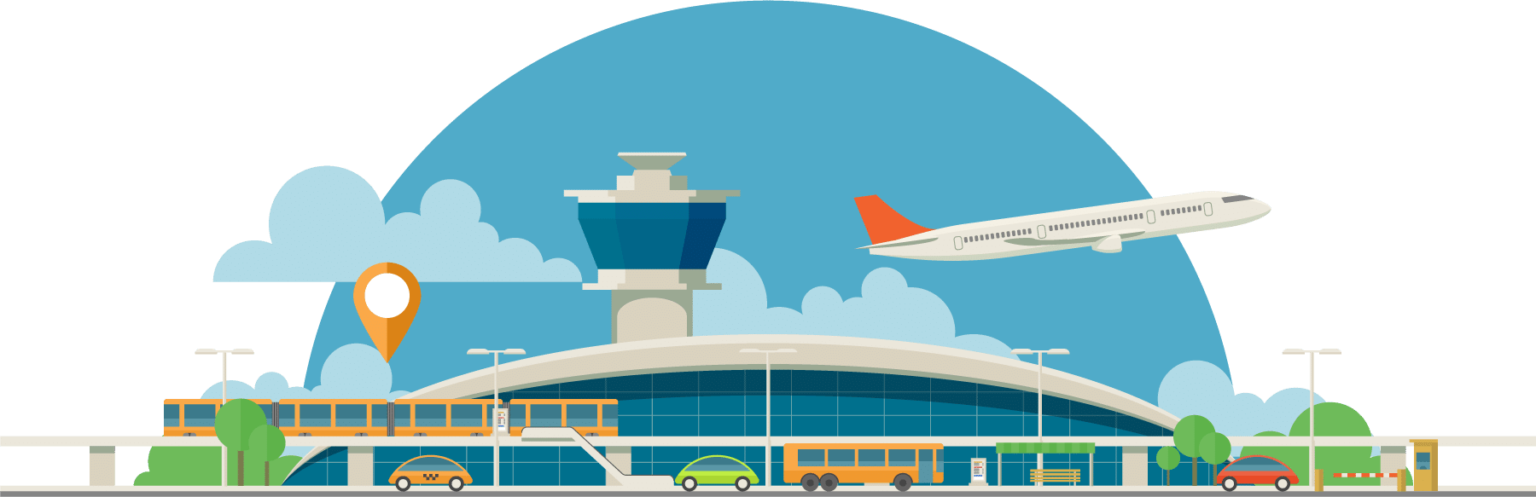

In [ ]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-28 01:01:37--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-28 01:01:38 (1.16 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

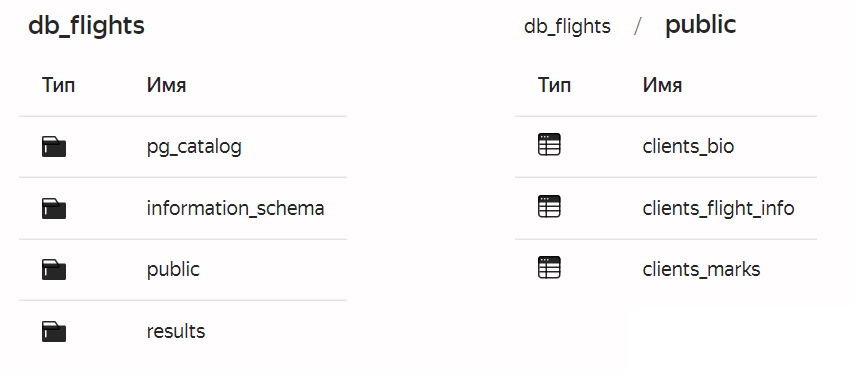



In [ ]:
conn = psycopg2.connect(dbname='db_flights', user='mlhs_student', password='mlhs_student', host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', port=6432)
df = pd.read_sql('''
select marks.*,
fl."Customer Type", fl."Type of Travel", fl."class", fl."Flight Distance", fl."Departure Delay in Minutes", fl."Arrival Delay in Minutes",
bio.gender, bio.age
from clients_marks marks
INNER JOIN clients_flight_info fl USING (id)
INNER JOIN clients_bio bio USING (id)
''', con=conn)
conn.close()

In [ ]:
df.set_index('id', inplace=True)
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
object_columns = ['gender', 'class', 'satisfaction', 'Customer Type', 'Type of Travel']
float_columns = list(set(df.columns) - set(object_columns))
df = df.astype({col: 'float' for col in float_columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Inflight wifi service              129505 non-null  float64
 1   Departure/Arrival time convenient  129500 non-null  float64
 2   Ease of Online booking             129506 non-null  float64
 3   Gate location                      129512 non-null  float64
 4   Food and drink                     129499 non-null  float64
 5   Online boarding                    129503 non-null  float64
 6   Seat comfort                       129502 non-null  float64
 7   Inflight entertainment             129504 non-null  float64
 8   On-board service                   129505 non-null  float64
 9   Leg room service                   129503 non-null  float64
 10  Baggage handling                   129501 non-null  float64
 11  Checkin service                    129507 no

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

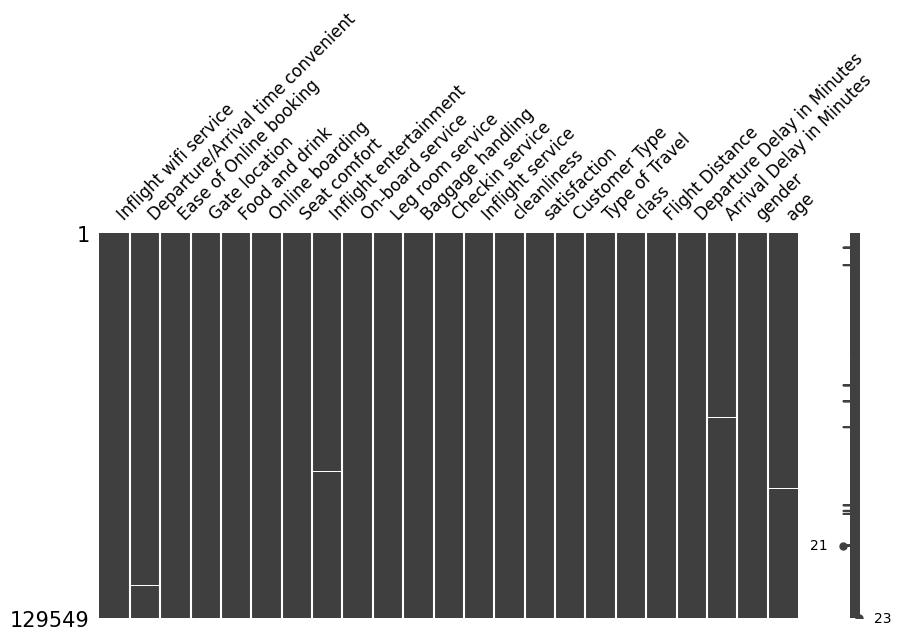

In [ ]:
missingno.matrix(df, figsize=(10,5), fontsize=12)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

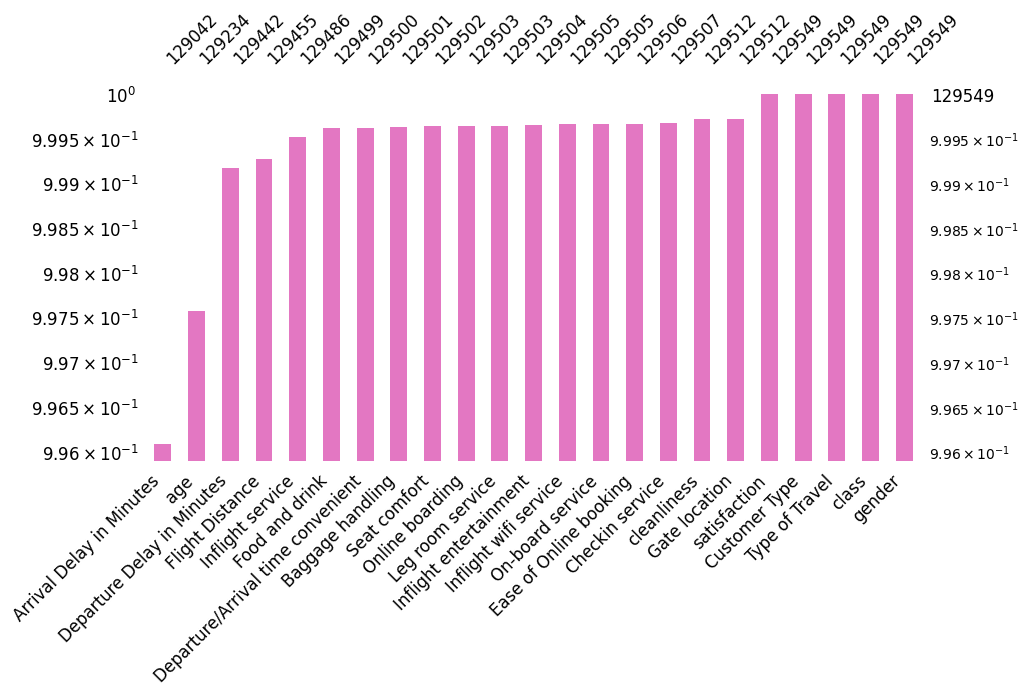

In [ ]:
missingno.bar(df, log=True, figsize=(10,5), color="tab:pink", fontsize=12,sort="ascending")

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df_train = df[df.satisfaction != '-']
df_train

Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
7                         3.0                                3.0   
13                        2.0                                2.0   
18                        2.0                                5.0   
31                        2.0                                2.0   
39                        3.0                                3.0   
...                       ...                                ...   
129831                    1.0                                3.0   
129837                    2.0                                4.0   
129838                    3.0                                5.0   
129839                    2.0                                4.0   
129846                    2.0                                5.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
7                          3.0            3.0             5.0   
13                         2.0            4.0             5.0   
18                         2.0            1.0             4.0   
31                         2.0            1.0             2.0   
39                         3.0            3.0             4.0   
...                        ...            ...             ...   
129831                     1.0            5.0             3.0   
129837                     2.0            3.0             2.0   
129838                     3.0            4.0             2.0   
129839                     2.0            3.0             3.0   
129846                     2.0            3.0             5.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  ...  cleanliness  \
id                                          ...                
7                    5.0               5.0  ...          4.0   
13                   2.0               4.0  ...          5.0   
18                   5.0               2.0  ...          1.0   
31                   4.0               5.0  ...          2.0   
39                   4.0               4.0  ...          5.0   
...                  ...               ...  ...          ...   
129831               1.0               1.0  ...          3.0   
129837               2.0               4.0  ...          5.0   
129838               3.0               3.0  ...          4.0   
129839               4.0               5.0  ...          3.0   
129846               4.0               2.0  ...          5.0   

                   satisfaction      Customer Type   Type of Travel     class  \
id                                                                              
7                     satisfied     Loyal Customer  Business travel  Business   
13      neutral or dissatisfied  disloyal Customer  Business travel       Eco   
18      neutral or dissatisfied     Loyal Customer  Personal Travel       Eco   
31      neutral or dissatisfied  disloyal Customer  Business travel  Business   
39                    satisfied     Loyal Customer  Business travel  Business   
...                         ...

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
55                        1.0                                1.0   
79                        5.0                                4.0   
126                       2.0                                5.0   
199                       4.0                                4.0   
263                       1.0                                2.0   
...                       ...                                ...   
129750                    4.0                                3.0   
129771                    3.0                                4.0   
129798                    2.0                                4.0   
129868                    3.0                                4.0   
129876                    4.0                                4.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
55                         1.0            1.0             1.0   
79                         0.0            3.0             4.0   
126                        2.0            4.0             5.0   
199                        4.0            4.0             2.0   
263                        1.0            3.0             2.0   
...                        ...            ...             ...   
129750                     3.0            3.0             4.0   
129771                     3.0            3.0             1.0   
129798                     2.0            2.0             3.0   
129868                     4.0            4.0             4.0   
129876                     4.0            2.0             4.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
55                  3.0           3.0                     3.0   
79                  4.0           4.0                     3.0   
126                 2.0           5.0                     5.0   
199                 4.0           5.0                     4.0   
263                 3.0           3.0                     2.0   
...                 ...           ...                     ...   
129750              5.0           4.0                     4.0   
129771              3.0           5.0                     1.0   
129798              5.0           5.0                     4.0   
129868              3.0           4.0                     4.0   
129876              4.0           1.0                     4.0   

        On-board service  Leg room service  ...  Inflight service  \
id                                          ...                     
55                   3.0               3.0  ...               3.0   
79                   3.0               0.0  ...               3.0   
126                  3.0               5.0  ...               5.0   
199                  4.0               4.0  ...               4.0   
263                  2.0               1.0  ...               2.0   
...                  ...               ...  ...               ...   
129750               4.0               5.0  ...               3.0   
129771               4.0               2.0  ...               4.0   
129798               4.0               2.0  ...               4.0   
129868               2.0               5.0  ...               4.0   
129876               5.0               4.0  ...               5.0   

        cleanliness   Customer Type   Type of Travel     class  \
id                                                               
55              2.0  Loyal Customer  Business travel  Business   
79              5.0  Loyal Customer  Personal Travel       Eco   
126             5.0  Loyal Customer  Personal Travel       Eco   
199             5.0  Loyal Customer  Business travel  Business   
263             1.0  Loyal Customer  Personal Travel  Business   
...             ...             ...              ...       ...   
12975

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [ ]:
columns = ['Customer Type', 'Type of Travel', 'class', 'gender'] # категориальные столбцы где nan - это строка, а не пустое значение
def delete_nan(dataset, columns):
      for col in columns:
          dataset[col] = dataset[col].apply(lambda x: np.nan if x=='nan' else x)
      return dataset
X_train = delete_nan(X_train, columns)
X_val = delete_nan(X_val, columns)

In [ ]:
X_train.isnull().sum()

Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
Customer Type                         52
Type of Travel                        70
class                                 66
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
gender                                 0
age                                  185
dtype: int64

In [ ]:
X_val.isnull().sum()

Inflight wifi service                  9
Departure/Arrival time convenient     13
Ease of Online booking                 9
Gate location                         11
Food and drink                        13
Online boarding                       14
Seat comfort                          18
Inflight entertainment                12
On-board service                       9
Leg room service                      14
Baggage handling                      11
Checkin service                       12
Inflight service                      19
cleanliness                           10
Customer Type                         14
Type of Travel                        18
class                                 23
Flight Distance                       18
Departure Delay in Minutes            23
Arrival Delay in Minutes             111
gender                                 0
age                                   76
dtype: int64

In [ ]:
# по всем столбцам X_train находим самое популярное значение
columns_delete_nan = X_train.columns
def top_all(dataset, columns_delete_nan):
    top_value = {}
    for col in columns_delete_nan:
        top_value[col] = dataset[col].mode()[0]
    return top_value
top_all_value = top_all(X_train, columns_delete_nan)

In [ ]:
# заменяем пустые значение на самое популярное
def replace_nan_top(dataset, top_dict):
    for col in top_all_value.keys():
          dataset[col] = dataset[col].fillna(top_all_value[col])
    return dataset
X_train = replace_nan_top(X_train, top_all_value)
X_val = replace_nan_top(X_val, top_all_value)

In [ ]:
X_train.isnull().sum()

Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
gender                               0
age                                  0
dtype: int64

In [ ]:
X_val.isnull().sum()

Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
gender                               0
age                                  0
dtype: int64

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
X_train.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count           72550.000000                       72550.000000   
mean                2.733687                           3.065017   
std                 1.362172                           1.552254   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72550.000000   72550.000000    72550.000000     72550.000000   
mean                 2.761006       2.982688        3.209318         3.256513   
std                  1.414843       1.316648        1.349963         1.372739   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72550.000000            72550.000000      72550.000000   
mean       3.445665                3.362150          3.383101   
std        1.346077                1.360862          1.333758   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72550.000000      72550.000000     72550.000000      72550.000000   
mean           3.352364          3.630255         3.309056          3.640234   
std            1.360180          1.227853         1.293114          1.215114   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean       3.291178      1329.018332                   15.859366   
std        1.343302      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%        2.000000       413.000000                    0.000000   
50%        3.000000       844.000000                    0.000000   
75%        4.000000      1744.000000                   12.000000   
max       45.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes           age  
count              72550.000000  72550.000000  
mean                  16.645968     40.098856  
std                   97.990293     20.658196  
min                    0.000000      0.000000  
25%                    0.000000     27.000000  
50%                    0.000000     40.000000  
75%                   13.000000     51.000000  
max                11760.000000    544.000000

In [ ]:
X_train.describe(include='object')

Customer Type   Type of Travel     class  gender
count            72550            72550     72550   72550
unique               2                2         3       2
top     Loyal Customer  Business travel  Business  Female
freq             59406            50054     34793   36816

In [ ]:
X_train['Customer Type'].value_counts(), X_train['Type of Travel'].value_counts(), X_train['class'].value_counts(), X_train['gender'].value_counts()

(Customer Type
 Loyal Customer       59406
 disloyal Customer    13144
 Name: count, dtype: int64,
 Type of Travel
 Business travel    50054
 Personal Travel    22496
 Name: count, dtype: int64,
 class
 Business    34793
 Eco         32546
 Eco Plus     5211
 Name: count, dtype: int64,
 gender
 Female    36816
 Male      35734
 Name: count, dtype: int64)

In [ ]:
X_val.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count           31094.000000                       31094.000000   
mean                2.732521                           3.064836   
std                 1.348038                           1.558570   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                40.000000                          35.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            31094.000000   31094.000000    31094.000000     31094.000000   
mean                 2.758989       2.978195        3.195215         3.252589   
std                  1.439010       1.290490        1.358929         1.414625   
min                  0.000000       1.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 45.000000      32.000000       45.000000        40.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  31094.000000            31094.000000      31094.000000   
mean       3.438477                3.359265          3.394578   
std        1.356474                1.358533          1.337013   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       36.000000               36.000000         40.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      31094.000000      31094.000000     31094.000000      31094.000000   
mean           3.367756          3.648775         3.306908          3.655303   
std            1.379536          1.224217         1.321872          1.204409   
min            0.000000          1.000000         0.000000          1.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           40.000000         40.000000        45.000000         35.000000   

        cleanliness  Flight Distance  Departure Delay in Minutes  \
count  31094.000000     31094.000000                31094.000000   
mean       3.286776      1316.469480                   15.666945   
std        1.345356      4379.003672                   80.658377   
min        0.000000         0.000000                    0.000000   
25%        2.000000       417.000000                    0.000000   
50%        3.000000       845.000000                    0.000000   
75%        4.000000      1744.000000                   12.000000   
max       40.000000    255522.000000                11011.000000   

       Arrival Delay in Minutes           age  
count              31094.000000  31094.000000  
mean                  16.871776     39.955779  
std                  131.103562     19.549492  
min                    0.000000      0.000000  
25%                    0.000000     27.000000  
50%                    0.000000     40.000000  
75%                   13.000000     51.000000  
max                14006.000000    612.000000

In [ ]:
X_val.describe(include='object')

Customer Type   Type of Travel     class  gender
count            31094            31094     31094   31094
unique               2                2         3       2
top     Loyal Customer  Business travel  Business  Female
freq             25315            21457     14783   15774

In [ ]:
X_val['Customer Type'].value_counts(), X_val['Type of Travel'].value_counts(), X_val['class'].value_counts(), X_val['gender'].value_counts()

(Customer Type
 Loyal Customer       25315
 disloyal Customer     5779
 Name: count, dtype: int64,
 Type of Travel
 Business travel    21457
 Personal Travel     9637
 Name: count, dtype: int64,
 class
 Business    14783
 Eco         14053
 Eco Plus     2258
 Name: count, dtype: int64,
 gender
 Female    15774
 Male      15320
 Name: count, dtype: int64)

Данные содержат аномалии практически во всех числовых столбцах. Например:

*   Возраст пассажира принимает 544, что указывает на ошибку в данных.
*   Согласно квартилям (25, 50, 75), оценки качества полёта должны быть в пределах 5-балльной шкалы, однако в данных встречаются значения значительно выше. Также присутствуют пассажиры, которые вообще ничего не оценивали (минимальные значения равны 0).
*   Максимальное значение расстояния полёта в 379 620 км, а также минимальное значение 0 км явно нереалистичны.
*   Задержки отправления и прибытия значения до 6 дней (максимум) выглядят неправдоподобно.

Что касается категориальных признаков:

*   Пол: количество мужчин и женщин примерно одинаково.
*   Классы обслуживания: бизнес- и эконом-классы имеют сопоставимое количество пассажиров, тогда как эконом плюс явно менее популярен.
*   Цель путешествия: деловых поездок заметно больше, чем туристических.
*   Лояльность: количество лояльных клиентов превышает количество нелояльных.

Соответственно из данных можно сделать вывод, что присутствуют выбросы по всем числовым столбцам.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
# функция удаления выбросов
def remove_outliers(dataset, y, column_numbers):
    quantiles = dataset[column_numbers].quantile(0.996)
    indices_to_keep = dataset.index
    for col in column_numbers:
        indices_to_keep = indices_to_keep.intersection(dataset[dataset[col] <= quantiles[col]].index)

    dataset = dataset.loc[indices_to_keep]
    y = y.loc[indices_to_keep]

    return dataset, y

In [ ]:
numeric_cols = X_train.select_dtypes(include='number').columns
X_train, y_train = remove_outliers(X_train, y_train, numeric_cols)
X_val, y_val = remove_outliers(X_val, y_val, numeric_cols)

In [ ]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
import math

In [ ]:
def plot_ordinal(cols, df, y):
    num_cols = len(cols)
    rows = math.ceil(num_cols / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(18, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(data=df, x=col, hue=y, ax=axes[i], palette="magma")
        axes[i].set_title(f"Распределение {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Количество")
        axes[i].legend(title="Satisfaction")

    # Убираем лишние оси
    for ax in axes[num_cols:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_continuous(cols, df, y):
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))

        # KDE-плот
        sns.kdeplot(data=df, x=col, hue=y, fill=True, ax=axes[0], palette="magma")
        axes[0].set_title(f"Распределение {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Плотность")

        # Boxplot
        sns.boxplot(data=df, x=y, hue=y, y=col, ax=axes[1], palette="magma")
        axes[1].set_title(f"Ящик с усами для {col}")
        axes[1].set_xlabel("Satisfaction")
        axes[1].set_ylabel(col)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_categorical(cols, df, y):
    num_cols = len(cols)
    rows = math.ceil(num_cols / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(18, 3 * rows))  # 4 графика в строке
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(data=df, x=col, hue=y, ax=axes[i], palette="magma")
        axes[i].set_title(f"Распределение {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Количество")
        axes[i].legend(title="Satisfaction")

    # Убираем лишние оси
    for ax in axes[num_cols:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
categorical_cols.remove('satisfaction')

Отрисовка.

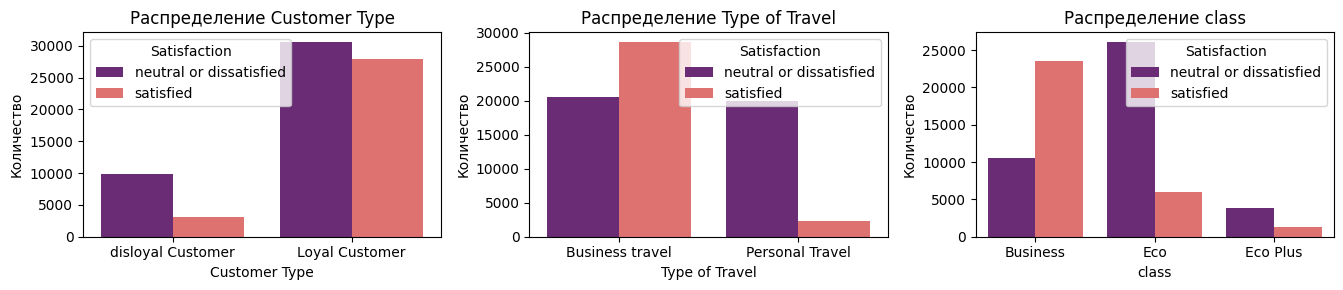

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

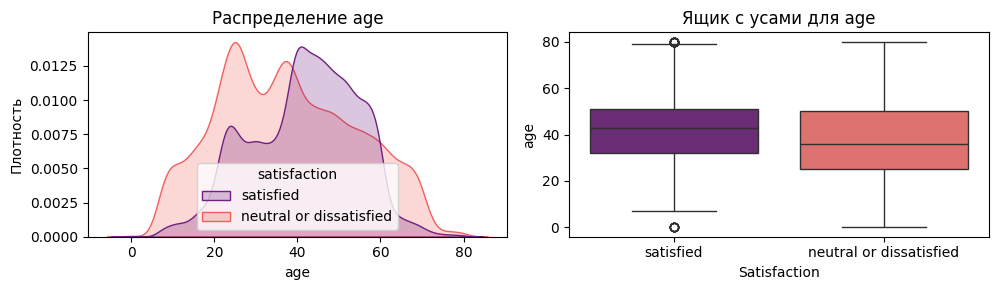

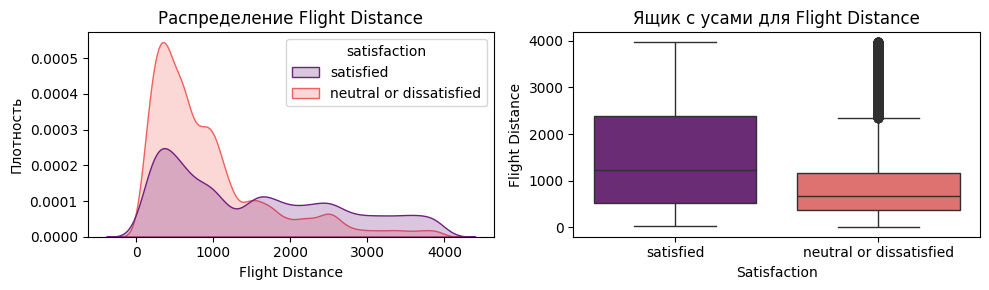

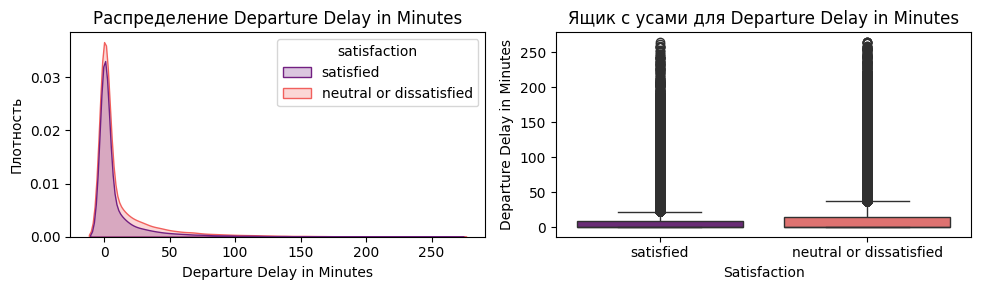

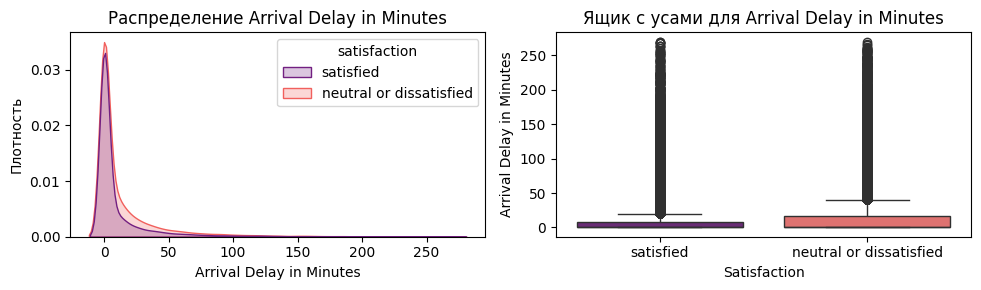

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

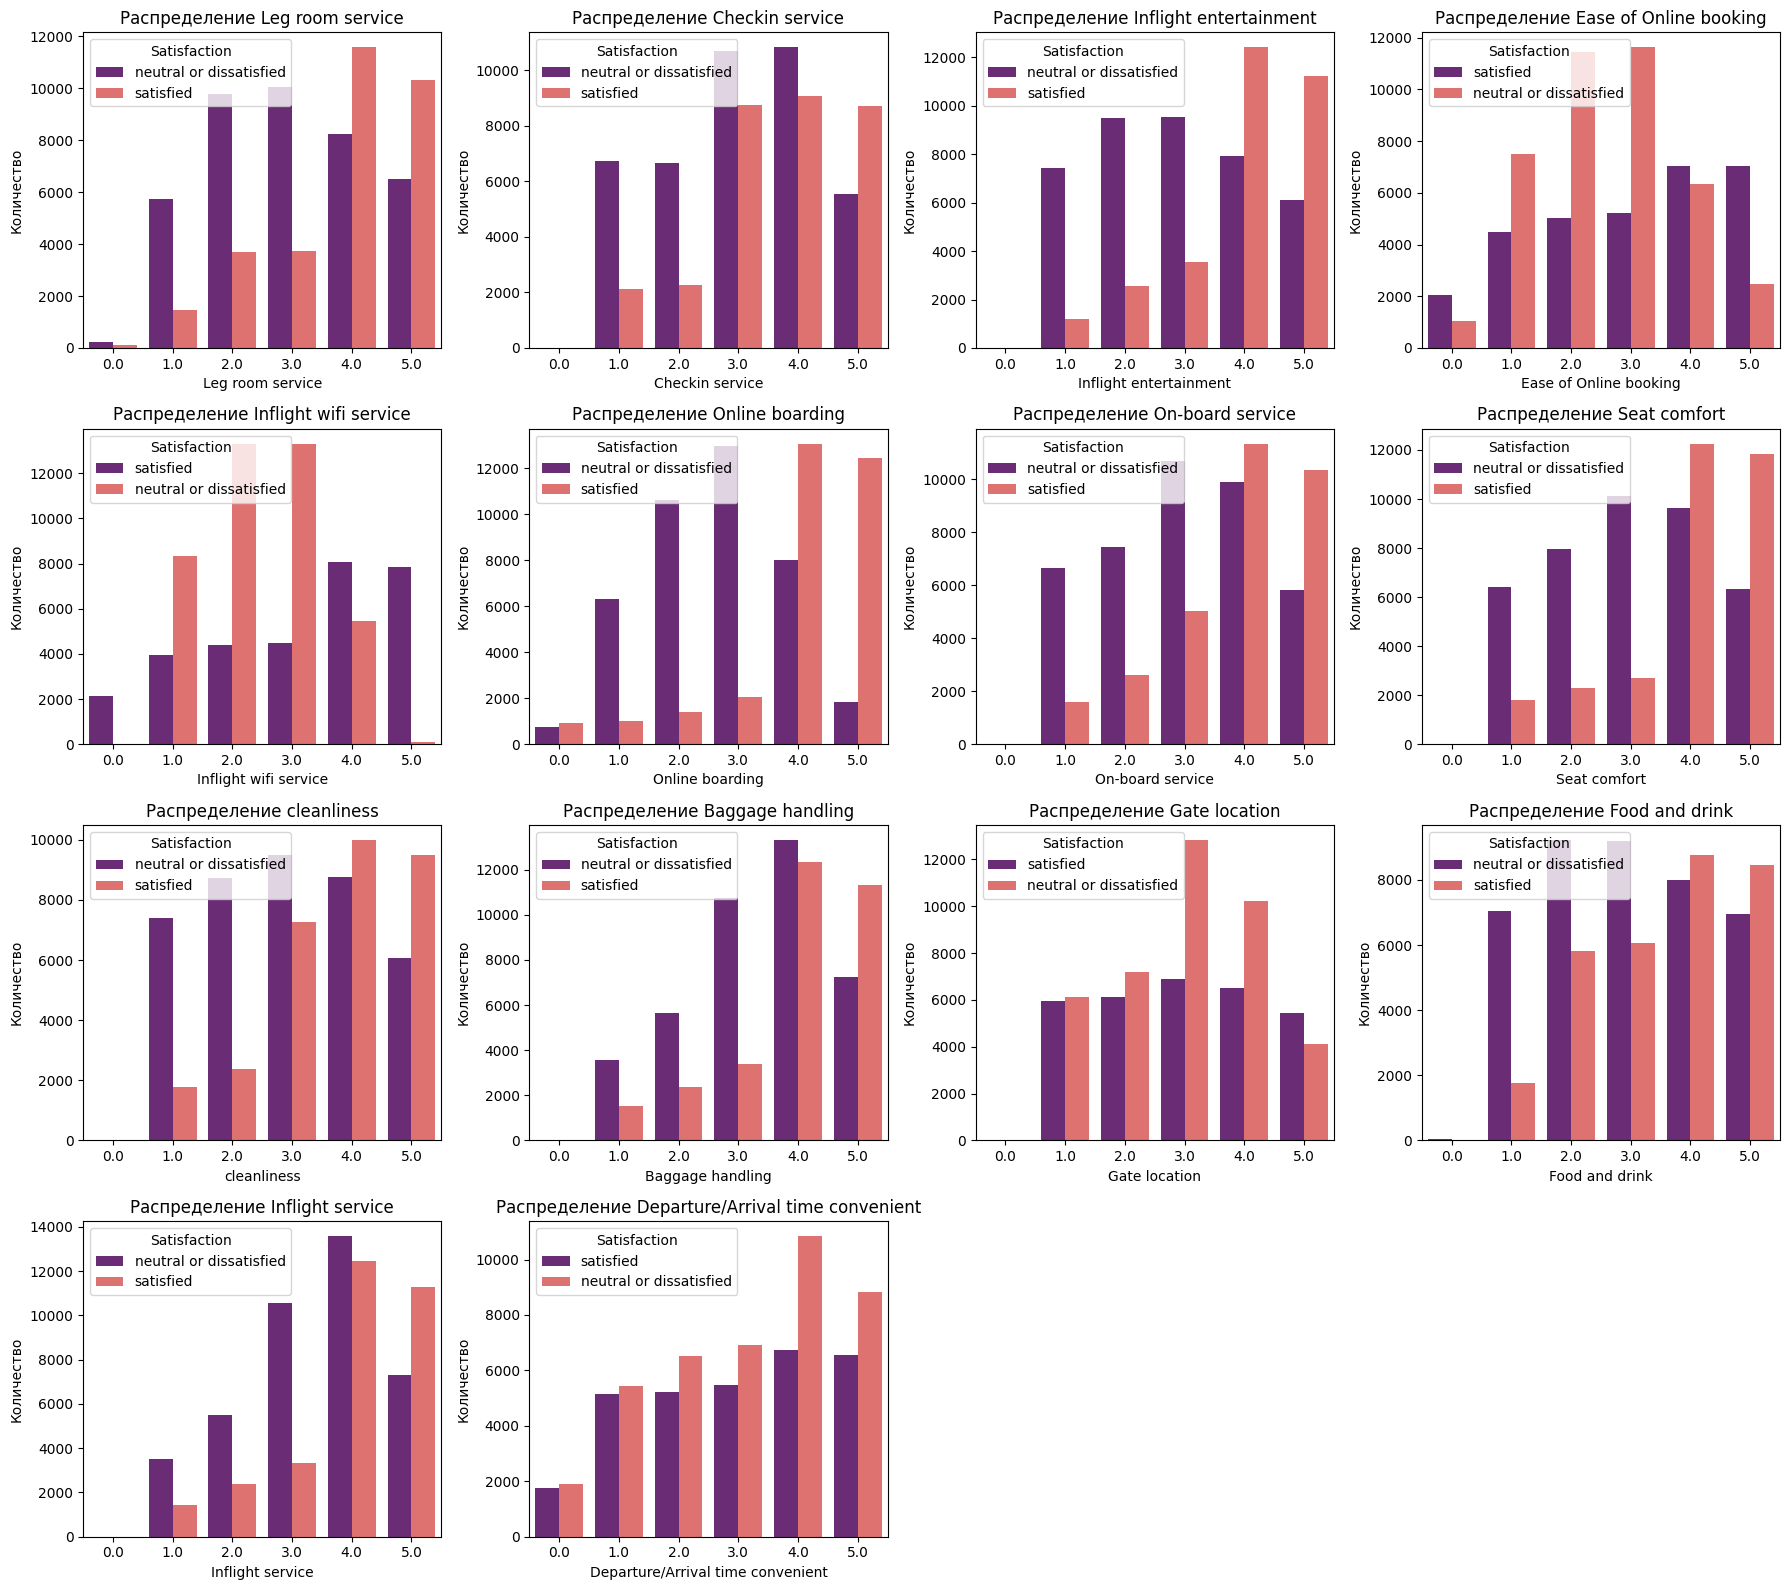

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

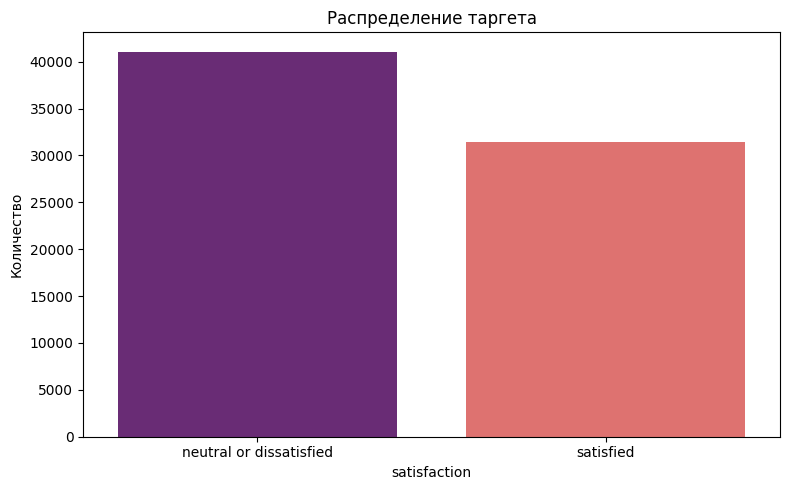

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, hue=y_train, palette="magma")
plt.title("Распределение таргета")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы:
* Все признаки распределны неравномерно
* Классы в таргет не сбалансированы
* Departure Delay in Minutes и Arrival Delay in Minutes имеют очень много выбросов, но скорее всего это из-за того, что очень редко люди ждут прибытия и отправки, поэтому ящик с усами показывает что дольше 50 минут ожидания - это выброс, распределение при этом показывают, что задержки мало влияют на оценку пассажиров
* Распредление возраста показывает, что самы довольные пассажиры в возрасте 40 лет, а самые недовольные 20
* Распределение расстояния: довольных полётом сильно меньше, чем недовольных. Очень сильно заметно это, когда расстное около 500 км, то есть можно сделать вывод, что этот признак влияет на оценку пассажиров



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

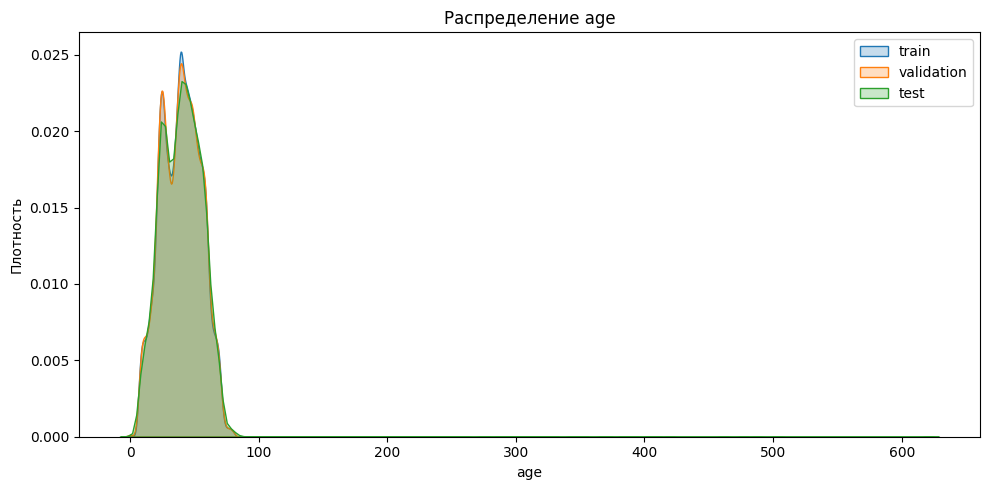

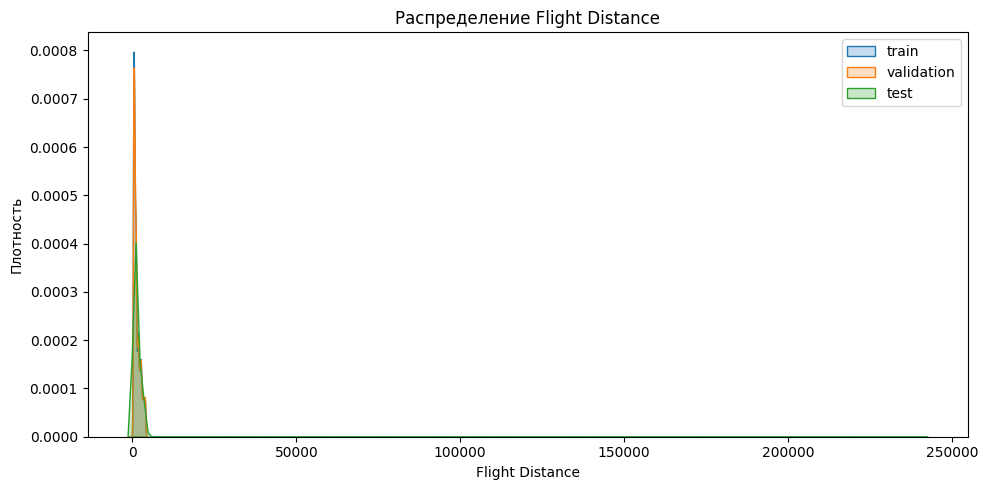

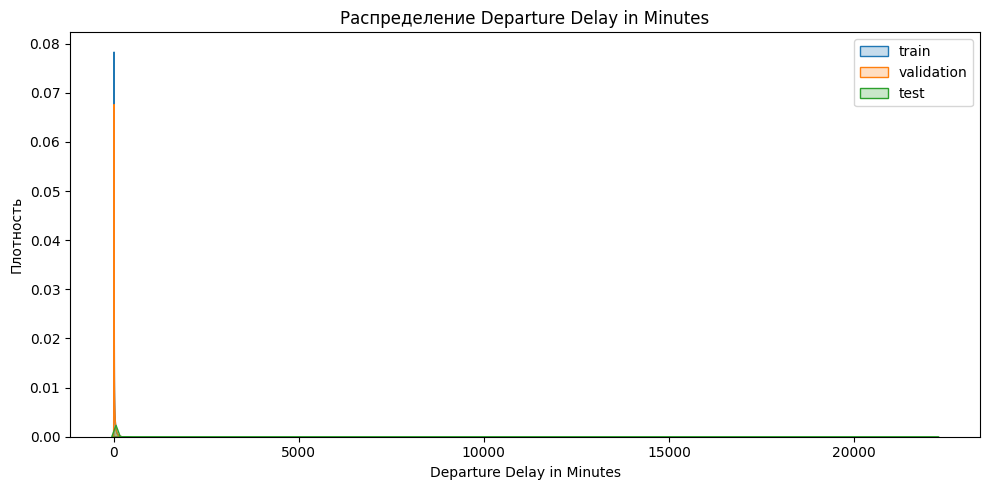

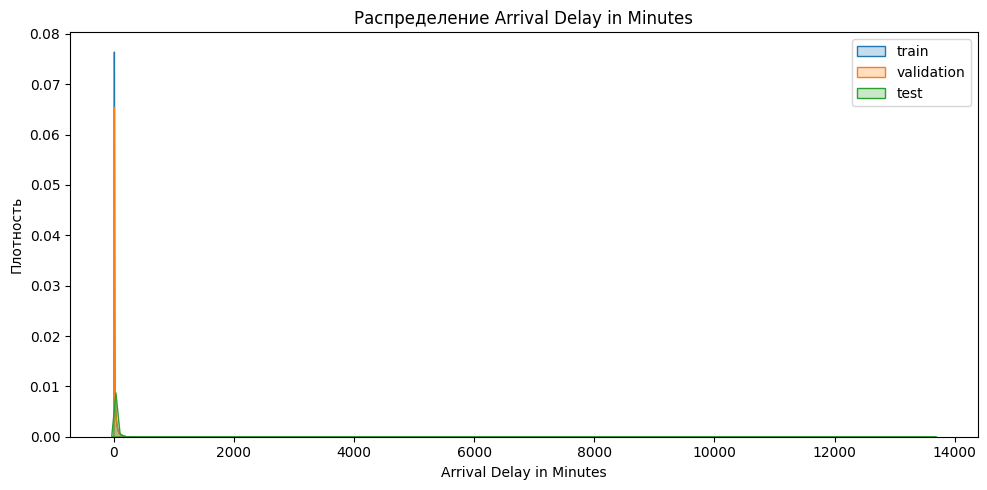

In [ ]:
def plot_graph(cols, datasets):
    for col in cols:
        fig, ax = plt.subplots(figsize=(10, 5))

        # KDE-плоты для каждого датасета
        for name, df in datasets.items():
            sns.kdeplot(data=df, x=col, fill=True, ax=ax, label=name)

        ax.set_title(f"Распределение {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Плотность")
        ax.legend()

        plt.tight_layout()
        plt.show()

plot_graph(cols=continuous_cols, datasets={"train": X_train, "validation": X_val, "test": df_test})

Распределения континуальных признаков довольно-таки похожи, но в тесте распределение везде меньше

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [ ]:
X_train['Departure Delay in Minutes'] = X_train['Departure Delay in Minutes'].apply(lambda x: math.log(x+1))
X_train['Arrival Delay in Minutes'] = X_train['Arrival Delay in Minutes'].apply(lambda x: math.log(x+1))

Построение.

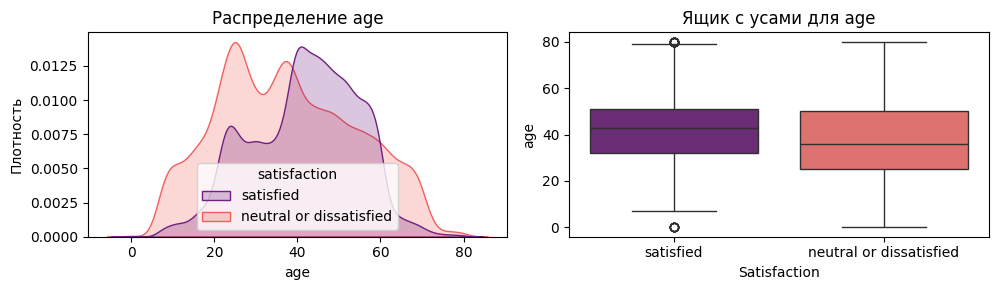

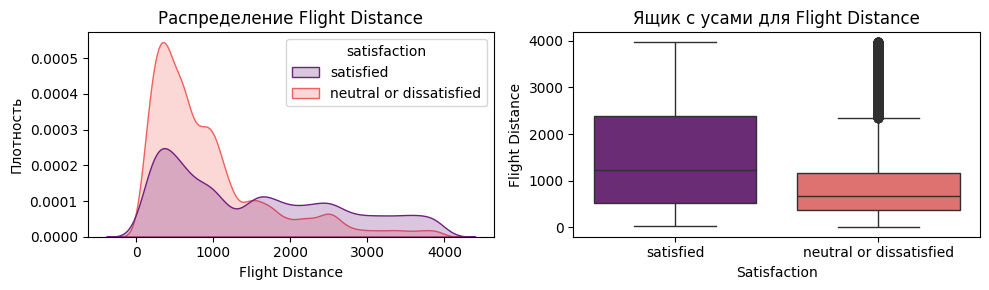

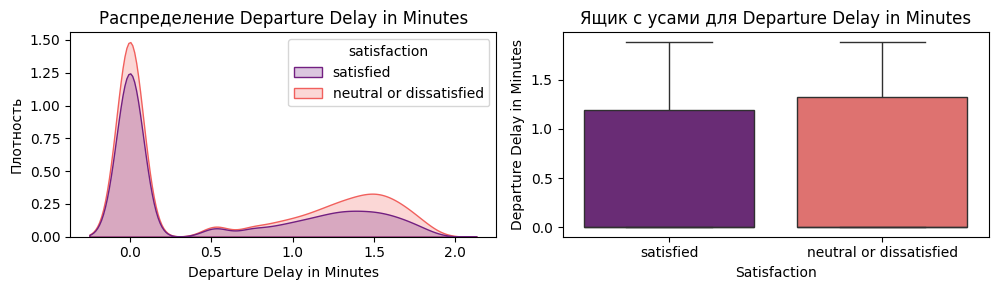

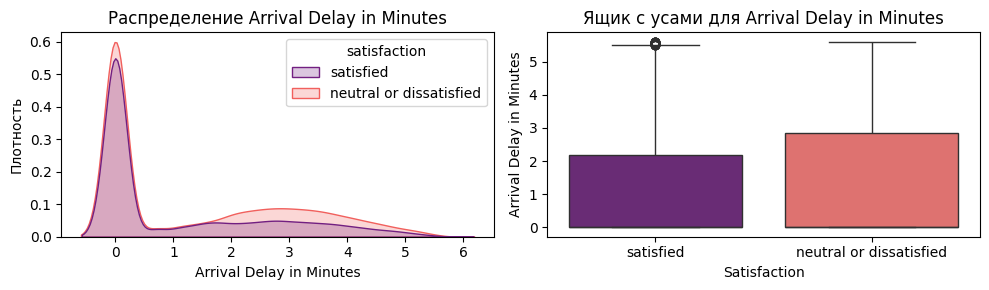

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

После логарифмического преобразования признаков Departure Delay in Minutes и Arrival Delay in Minutes, графики распределения стали более читабельными, что упрощает их анализ.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [ ]:
X = X_train[continuous_cols].copy()
X['satisfaction'] = y_train
X.head()

age  Flight Distance  Departure Delay in Minutes  \
id                                                         
2031   29.0            785.0                         0.0   
11597  45.0           3269.0                         0.0   
74668   8.0           1431.0                         0.0   
31602  48.0            602.0                         0.0   
51518  25.0            651.0                         0.0   

       Arrival Delay in Minutes             satisfaction  
id                                                        
2031                        0.0  neutral or dissatisfied  
11597                       0.0                satisfied  
74668                       0.0  neutral or dissatisfied  
31602                       0.0  neutral or dissatisfied  
51518                       0.0                satisfied

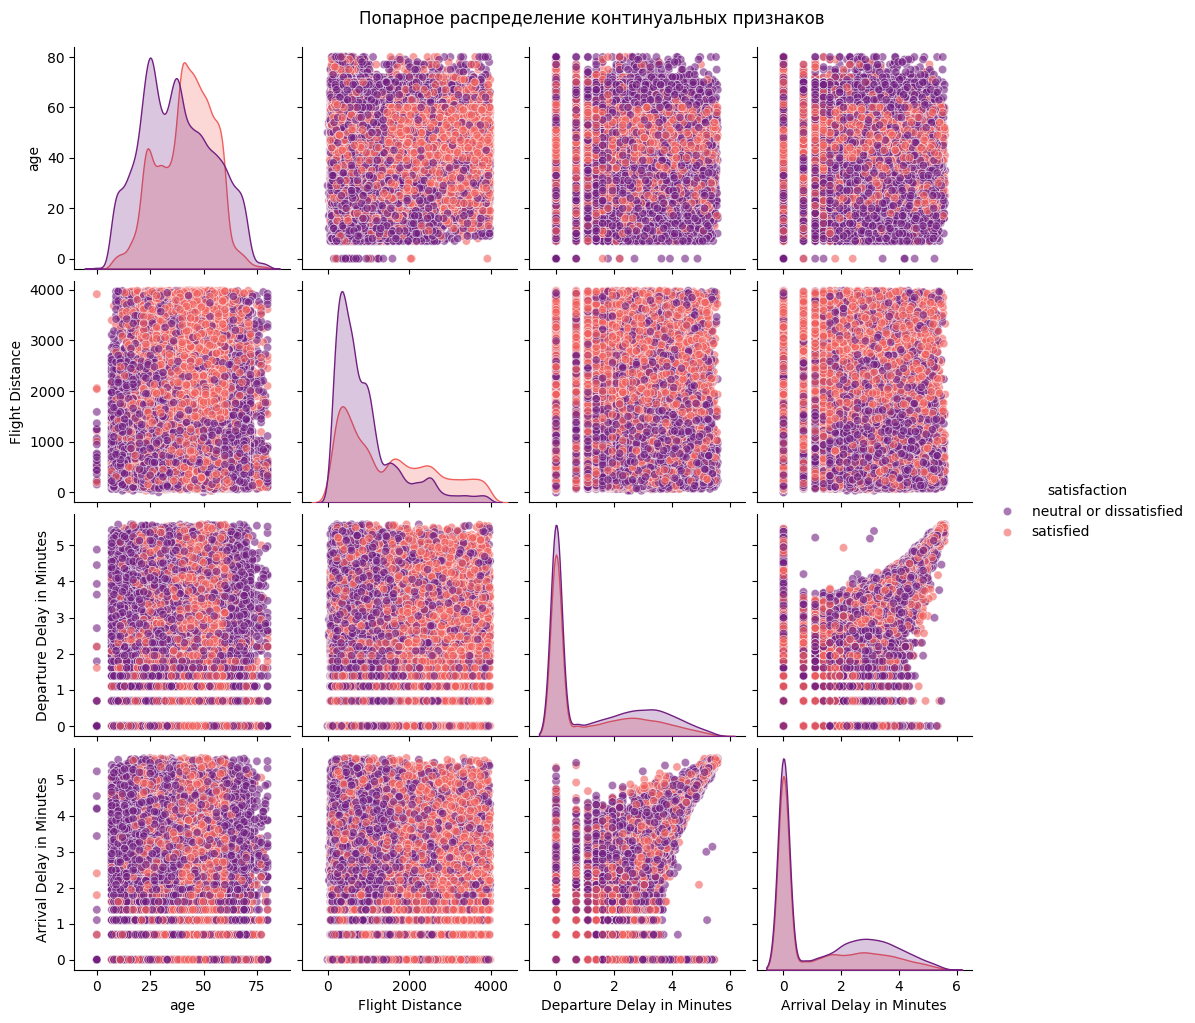

In [ ]:
# Ваш код ниже
pairplot = sns.pairplot(
    data=X,
    hue='satisfaction',
    palette="magma",
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)
# Настройка заголовка и подписи
pairplot.fig.suptitle("Попарное распределение континуальных признаков", y=1.02)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
def code_object(columns, X, y):
    y = y.apply(lambda x: 1 if x == 'satisfied' else 0)
    X = pd.get_dummies(X, columns=columns, drop_first=True, dtype = int)
    return X, y

In [ ]:
X_train_one, y_train_one = code_object(columns, X_train, y_train)
X_val_one, y_val_one = code_object(columns, X_val, y_val)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
model=DecisionTreeClassifier(random_state=42)
model.fit(X_train_one, y_train_one)
y_pred = model.predict(X_val_one)
print(f"Accuracy: {accuracy_score(y_pred, y_val_one):.2f}")

Accuracy: 0.91


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        model, X_train_one.values, y_train_one.values, X_val_one.values, y_val_one.values,
        loss='0-1_loss',
        random_seed=42)
error_dt, bias_dt, var_dt

(0.08729975807506211, 0.05266771282856022, 0.06986514319340918)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
print("Глубина дерева:", model.get_depth())
print("Количество листьев:", model.get_n_leaves())

Глубина дерева: 35
Количество листьев: 2916


Глубина дерева и количество листьев довольно-таки большие, что может указывать на переобучение

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [ ]:
importance_df = pd.DataFrame({
    'Feature': X_train_one.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Feature', ascending=True)

In [ ]:
importance_df

Feature  Importance
16           Arrival Delay in Minutes    0.009071
10                   Baggage handling    0.020180
11                    Checkin service    0.030544
18    Customer Type_disloyal Customer    0.032146
15         Departure Delay in Minutes    0.006184
1   Departure/Arrival time convenient    0.005844
2              Ease of Online booking    0.004741
14                    Flight Distance    0.024424
4                      Food and drink    0.003884
3                       Gate location    0.016016
7              Inflight entertainment    0.043650
12                   Inflight service    0.016293
0               Inflight wifi service    0.178618
9                    Leg room service    0.021330
8                    On-board service    0.009667
5                     Online boarding    0.361613
6                        Seat comfort    0.014853
19     Type of Travel_Personal Travel    0.150783
17                                age    0.022198
20                          class_Eco    0.013350
21                     class_Eco Plus    0.002072
13                        cleanliness    0.009793
22                        gender_Male    0.002748

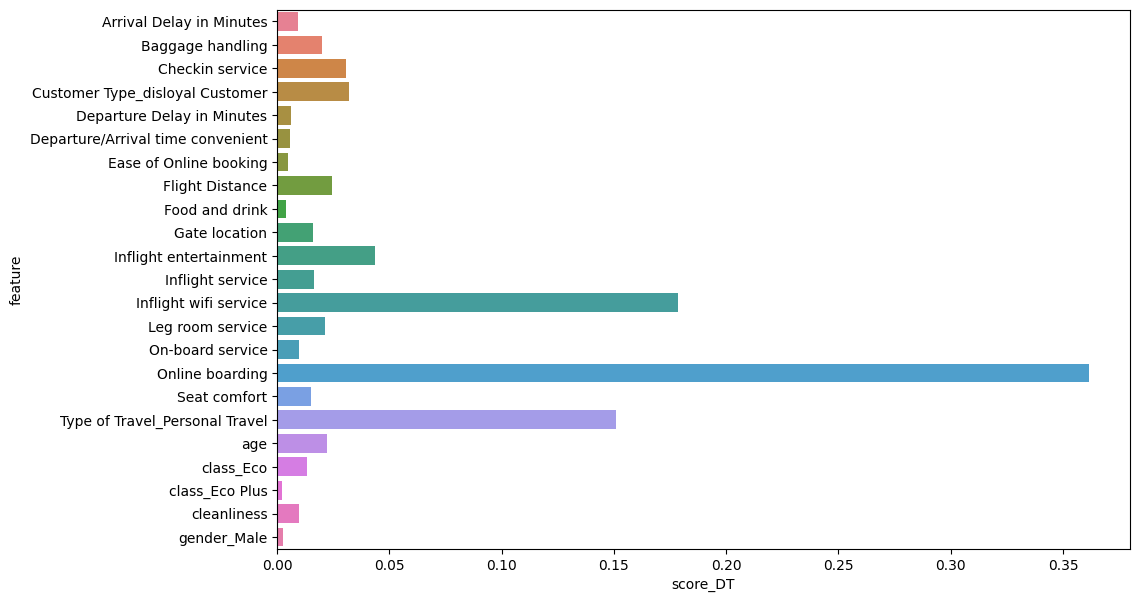

In [ ]:
plt.figure(figsize=(11, 7))
ax = sns.barplot(data=importance_df, x='Importance', y='Feature', hue = 'Feature', orient="y")
ax.set(xlabel = 'score_DT', ylabel = 'feature')
plt.show()

Топ 3 признака:


1.   Online boarding - 0.37
2.   Inflight wifi service - 0.18
3.   Type of Travel_Personal Travel	- 0.15





### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
X_top_two = X_train_one[['Online boarding', 'Inflight wifi service']]

In [ ]:
tree = DecisionTreeClassifier(max_depth = 5, random_state=42)
tree.fit(X_top_two, y_train_one)
y_pred = model.predict(X_val_one)
print(f"Accuracy: {accuracy_score(y_pred, y_val_one):.2f}")

Accuracy: 0.91


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

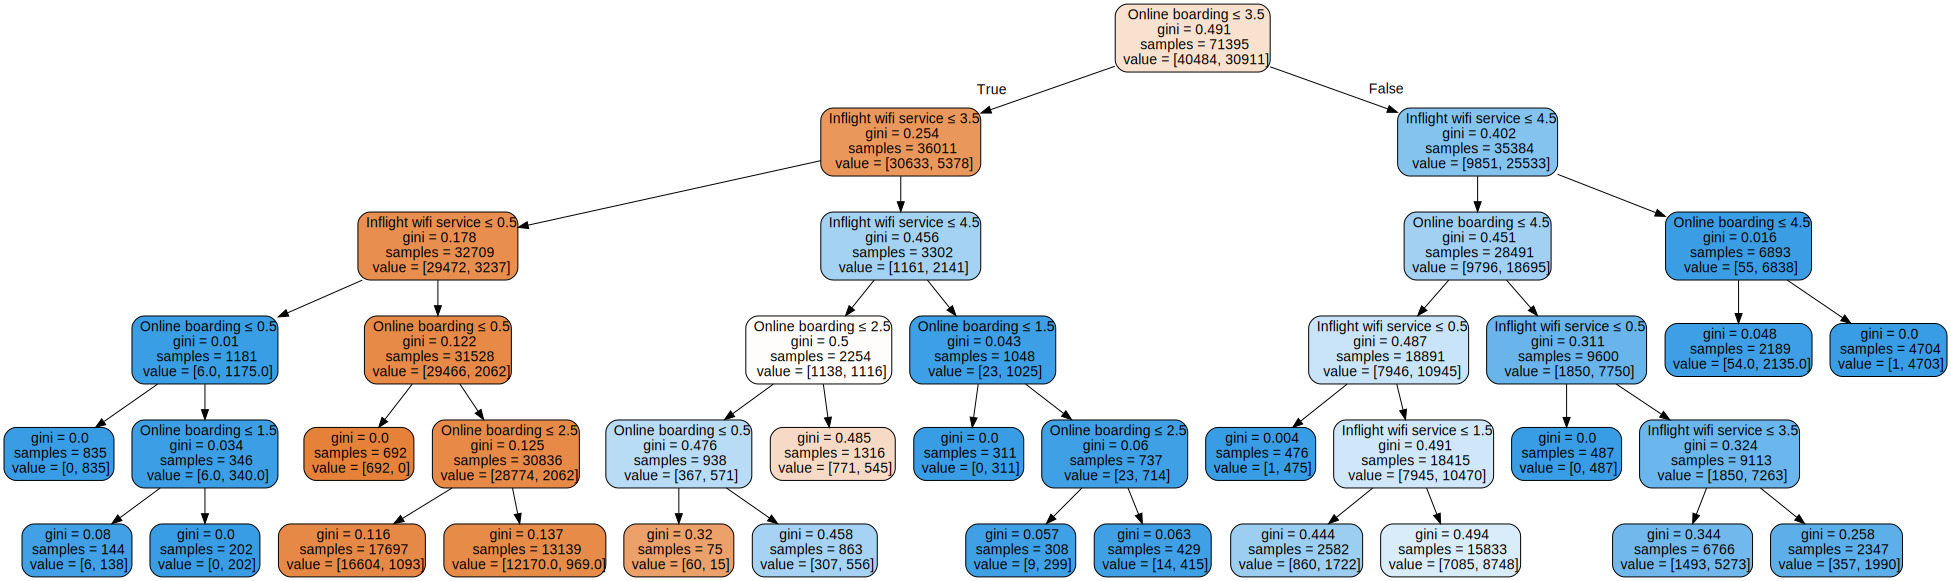

In [ ]:
# Визуализация дерева с помощью graphviz
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X_top_two.columns,
                           filled=True, rounded=True,
                           special_characters=True)
Source(dot_data)

В процессе построения дерева решений для классификации, при выборе пороговых значений для разбиения по количественным признакам, алгоритм рассматривает средние значения между соседними уникальными значениями признака. Если эти уникальные значения являются целыми числами, то средние между ними будут кратны 0.5.

https://habr.com/ru/articles/801515/

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

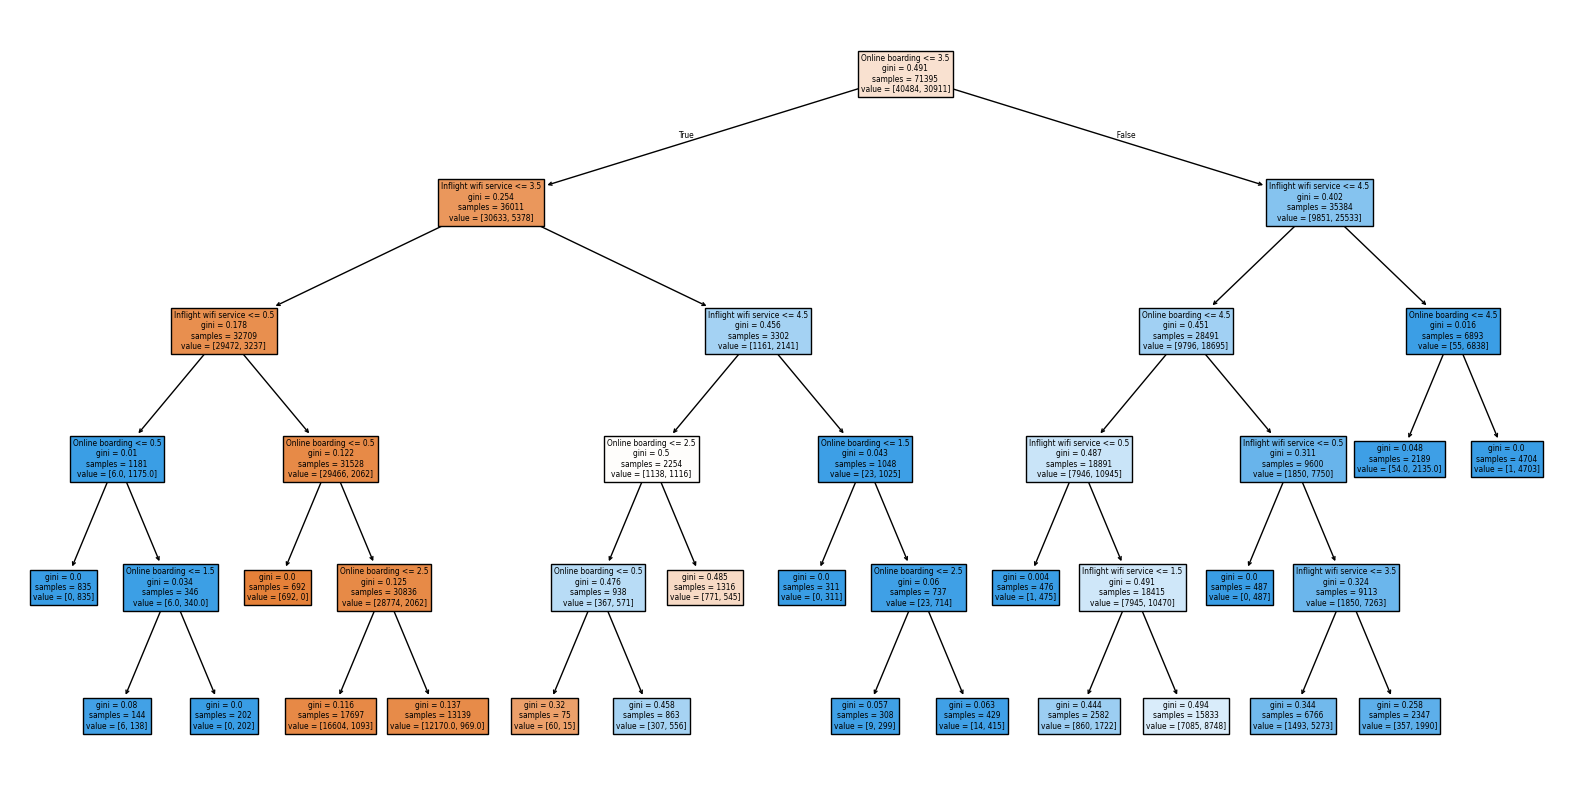

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X_top_two.columns)
plt.show()

Нет, дерево не симметричное. Симметричные деревья лучше, так как менее склонны к переобучению

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

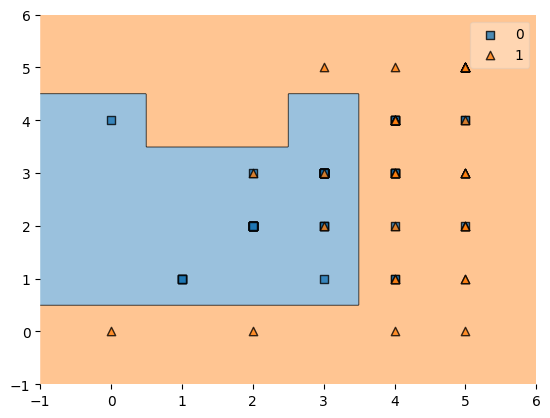

In [ ]:
plot_decision_regions(X_top_two.values[:100], y_train_one.values[:100], clf=tree)
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

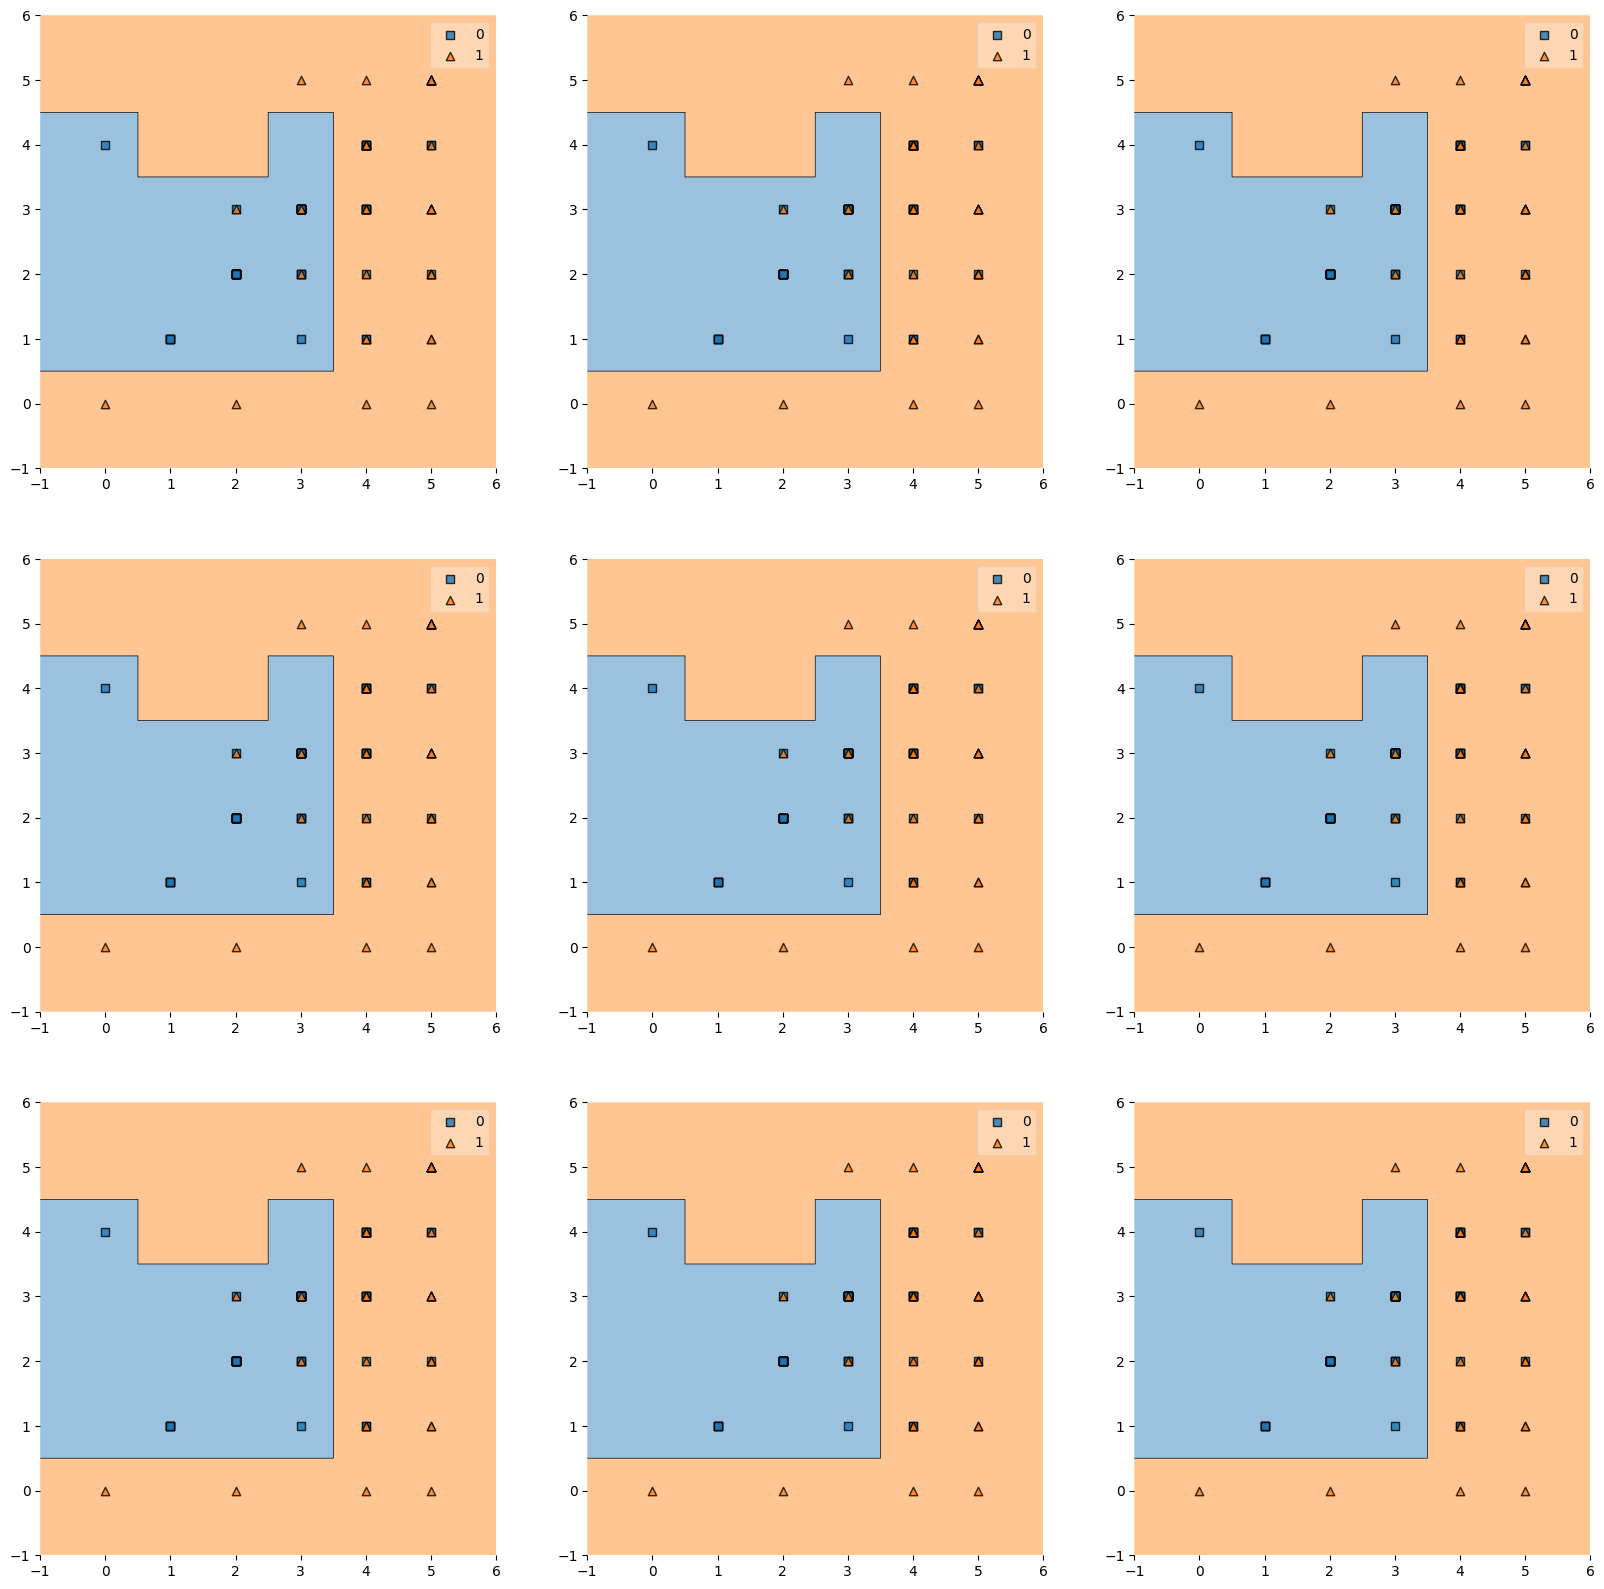

In [ ]:
# замените X_train_example на вашу переменную
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_top_two.index, size=X_top_two.shape[0] - 5000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_top_two.loc[inds, :], y_train_one[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_top_two.iloc[:100, :]), y=np.array(y_train_one[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_top_two, y_train_one)
    y_predicted_train = DT.predict(X_top_two)
    y_predicted_val = DT.predict(X_val_one[['Online boarding', 'Inflight wifi service']])
    accuracies_train.append(accuracy_score(y_train_one, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val_one, y_predicted_val))

CPU times: user 535 ms, sys: 2.6 ms, total: 537 ms
Wall time: 556 ms


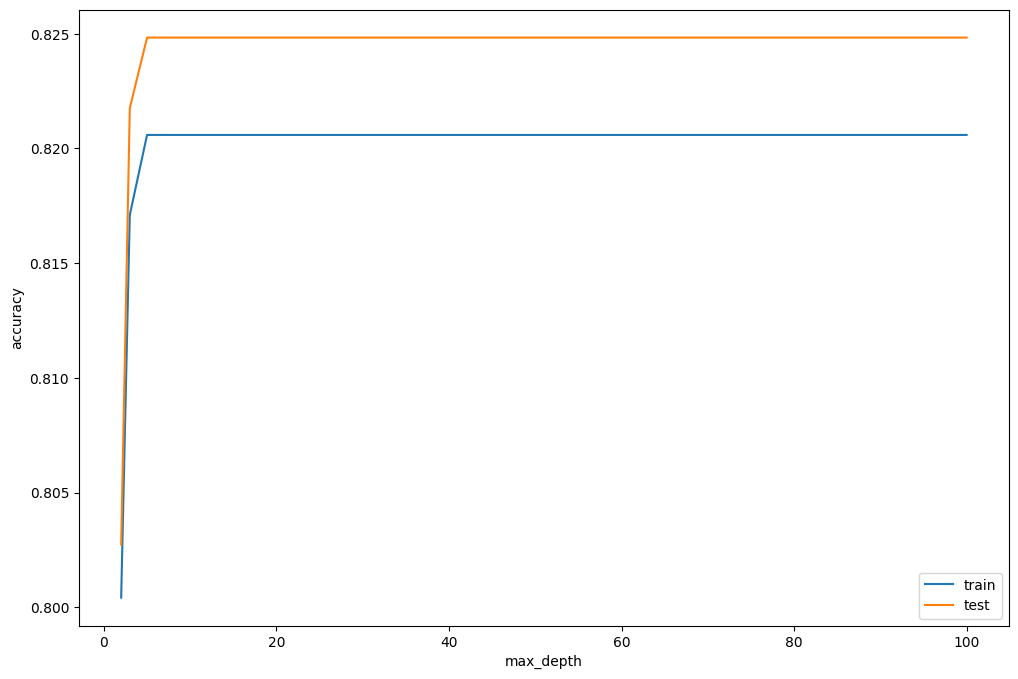

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 30),
    'max_features': ['auto', 'sqrt', 'log2']
}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3, scoring='accuracy')
gs.fit(X_train_one, y_train_one)
gs.best_estimator_, gs.best_score_

(DecisionTreeClassifier(criterion='entropy', max_depth=19, max_features='sqrt',
                        random_state=42),
 0.9339589714756116)

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(gs, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_one, y_train_one)
y_pred = rfc.predict(X_val_one)
print(f"Accuracy: {accuracy_score(y_pred, y_val_one):.2f}")

Accuracy: 0.96


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

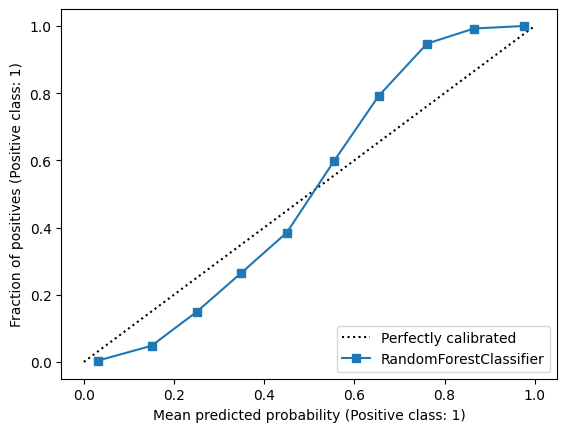

In [ ]:
CalibrationDisplay.from_estimator(rfc, X_val_one, y_val_one, n_bins=10)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья могут предсказывать вероятности, но они часто некорректны из-за переобучения и структуры дерева.


### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

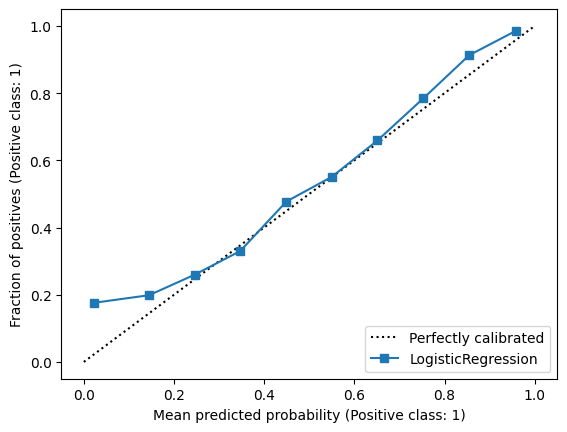

In [ ]:
st=StandardScaler()
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(st.fit_transform(X_train_one), y_train_one)

disp = CalibrationDisplay.from_estimator(logreg, st.transform(X_val_one), y_val_one, n_bins=10)

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Калибровочная прямая практически совпадает с биссектрисой и отклоняется только в области низких вероятностей, то есть модель хорошо откалибрована


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
proba_valid = rfc.predict_proba(X_val_one)[:, 1]

In [ ]:
log_reg = LogisticRegression().fit(proba_valid.reshape(-1, 1), y_val_one)
proba_test_rfc_logreg = log_reg.predict_proba(rfc.predict_proba(X_val_one)[:, 1].reshape(-1, 1))[:, 1]

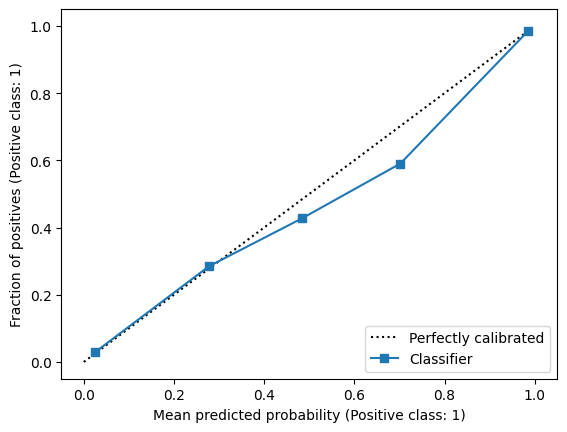

In [ ]:
disp = CalibrationDisplay.from_predictions(y_val_one, proba_test_rfc_logreg)

In [ ]:
iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_valid, y_val_one)
proba_test_rfc_isoreg = iso_reg.predict(rfc.predict_proba(X_val_one)[:, 1])

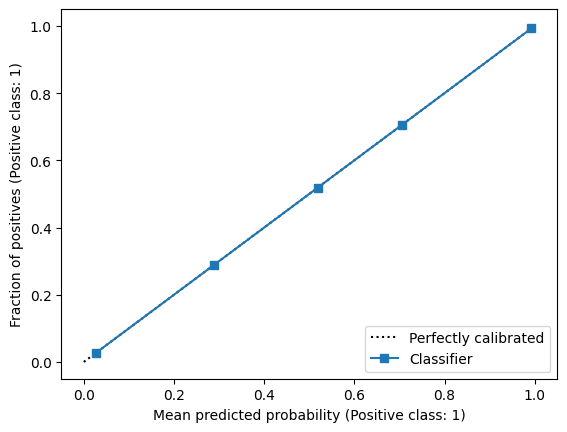

In [ ]:
disp = CalibrationDisplay.from_predictions(y_val_one, proba_test_rfc_isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

*   Гистограммная калибровка - этот метод делит вероятностный интервал [0, 1] на несколько бинов (например, отрезков 0.1) и вычисляет истинные частоты положительных примеров в каждом из них.
*   Калибровка Платта - применение сигмоиды поверх другой модели

https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti



### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        rfc, X_train_one.values, y_train_one.values, X_val_one.values, y_val_one.values,
        loss='0-1_loss',
        random_seed=42)
error_dt, bias_dt, var_dt

(0.041179220609389305, 0.03913299333071793, 0.009834902576173664)

Да, отличаются. Для случайного леса ошибка и по смещению, и по разбросу меньше, чем у дерева.
Случайный лес в данном случае показывает сбалансированное поведение. Низкое смещение говорит о способности модели находить сложные зависимости в данных. Низкая дисперсия подтверждает устойчивость модели и ее способность обобщать данные.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        logreg, X_train_one.values, y_train_one.values, X_val_one.values, y_val_one.values,
        loss='0-1_loss',
        random_seed=42)
error_dt, bias_dt, var_dt

(0.182877925984046, 0.1821956322740944, 0.012731463318948609)

Результат незначительно хуже, чем у дерева и леса, так как данная модель линейная и довольно-таки чувствительна к выбросам

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import loguniform
param_dist = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': np.arange(50, 200, 25),
    'max_depth': list(np.arange(5, 30, 1)),
    'min_weight_fraction_leaf': loguniform(1e-6, 1e-1),
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=42)

rs = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, scoring='accuracy', cv=3)
rs.fit(X_train_one, y_train_one)
rs.best_estimator_, rs.best_score_

(RandomForestClassifier(max_depth=14, max_features='log2',
                        min_weight_fraction_leaf=0.00019069966103000456,
                        n_estimators=175, random_state=42),
 0.9503186589664329)

In [ ]:
rs = RandomForestClassifier(criterion='entropy', max_depth=26,
                        min_weight_fraction_leaf=7.485022950356932e-06,
                        random_state=42)
rs.fit(X_train_one, y_train_one)
y_pred = rs.predict(X_val_one)
print(f"Accuracy: {accuracy_score(y_pred, y_val_one):.2f}")

Accuracy: 0.96


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_one[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train_one)

    errors.append(1 - clf.oob_score_)

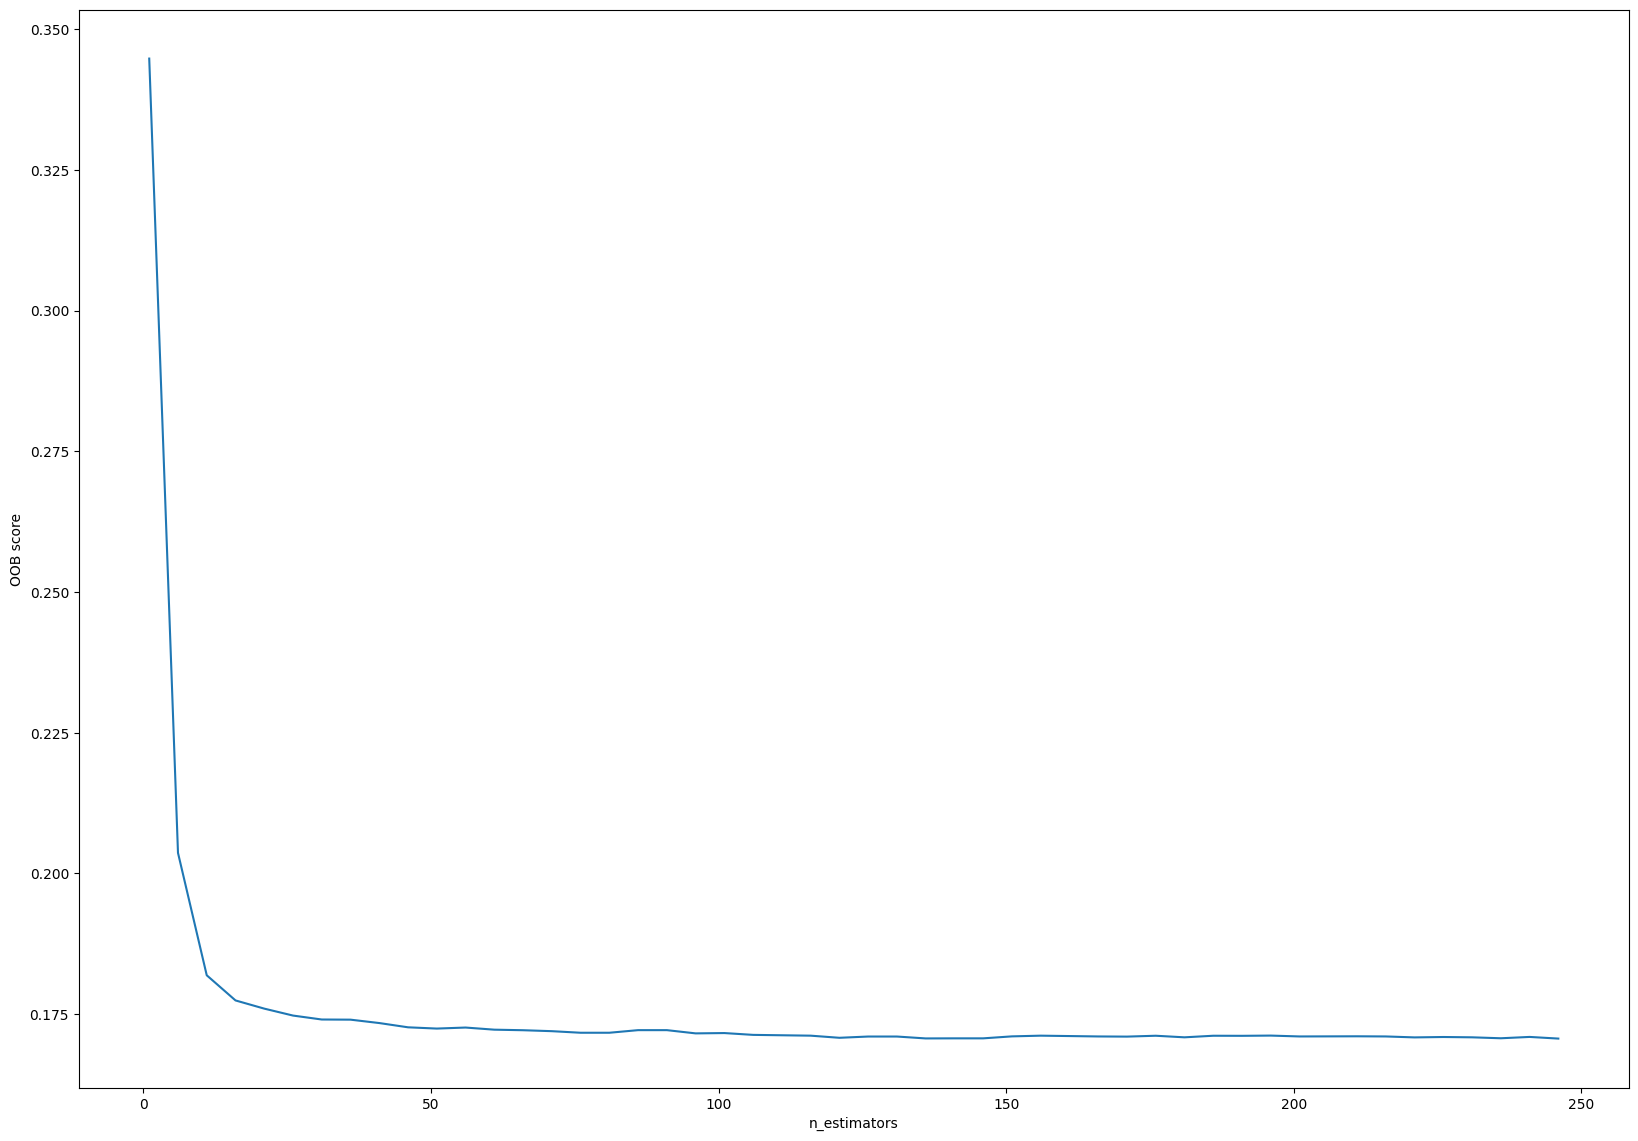

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
importance_df_tree = pd.DataFrame({
    'Feature': X_train_one.columns,
    'Importance': rs.feature_importances_
}).sort_values(by='Feature', ascending=True)

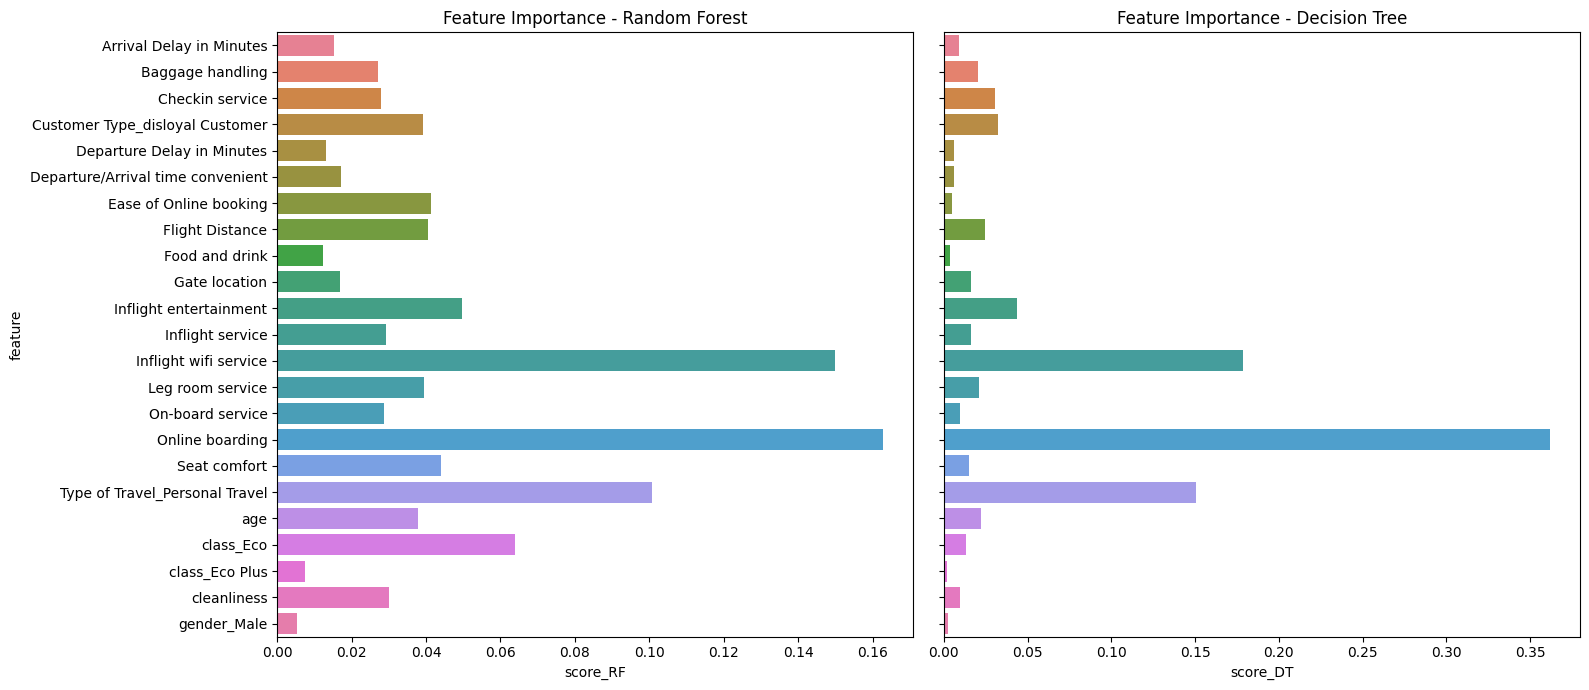

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)  # 1 строка, 2 столбца

sns.barplot(data=importance_df_tree, x='Importance', y='Feature', hue='Feature', orient="h", ax=axes[0])
axes[0].set_title('Feature Importance - Random Forest')
axes[0].set(xlabel='score_RF', ylabel='feature')

sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', orient="h", ax=axes[1])
axes[1].set_title('Feature Importance - Decision Tree')
axes[1].set(xlabel='score_DT', ylabel='')

plt.tight_layout()
plt.show()

Топ 3 признака не изменились, но важность их стала меньше, так, например, важность Online boarding уменьшилась в 2 раза

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
with open('RFC.pkl', 'wb') as f:
    pickle.dump(rs, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

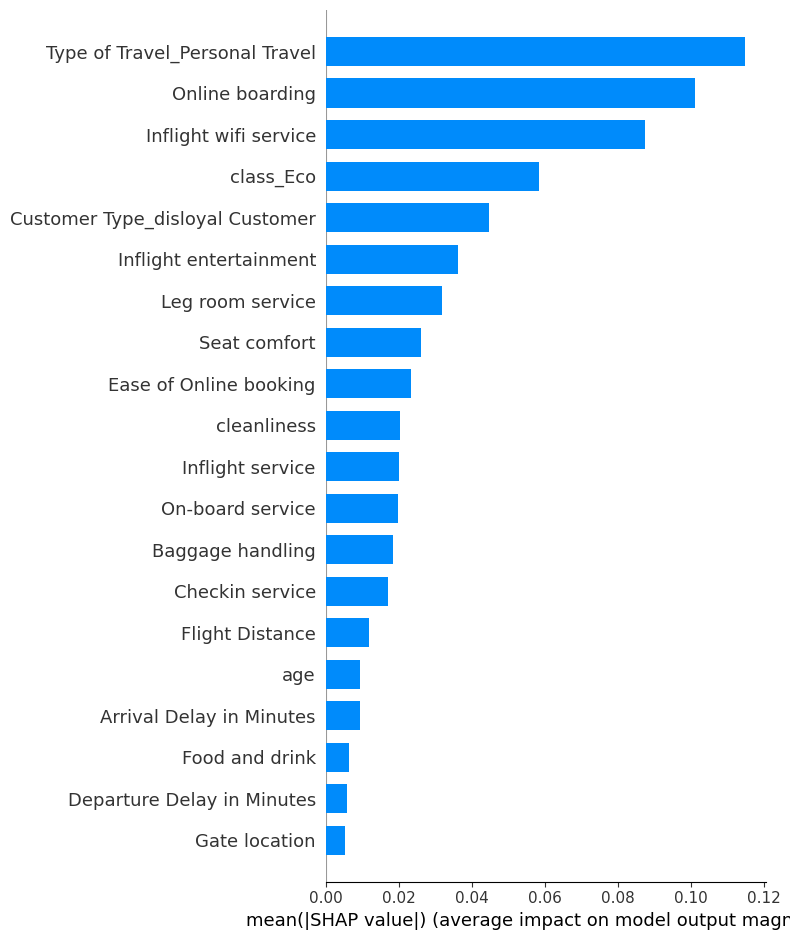

In [ ]:
sample_indices = np.random.choice(X_val_one.shape[0], size=1000, replace=False)
X_val_sample = X_val_one.iloc[sample_indices]

explainer = shap.TreeExplainer(rs)
shap_values = explainer.shap_values(X_val_sample)
shap.summary_plot(shap_values[:,:,1], X_val_sample, plot_type="bar")

Топ 3 признака теперь изменились:

* Type of travel теперь на 1 месте, хотя был раньше на 3
* У Online boarding и inflight wifi service важность уменьшилась

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

Waterfall Plot помогает понять, как каждый признак влияет на конкретное предсказание модели. Он отображает последовательное влияние признаков, показывая, какие из них увеличивают или уменьшают итоговое значение предсказания.

С помощью графика Dependence Plot можно исследовать зависимость между значением признака и его SHAP-значением. Это полезно для выявления нелинейных зависимостей и взаимодействий между признаками.

https://habr.com/ru/companies/ods/articles/599573/#3


### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

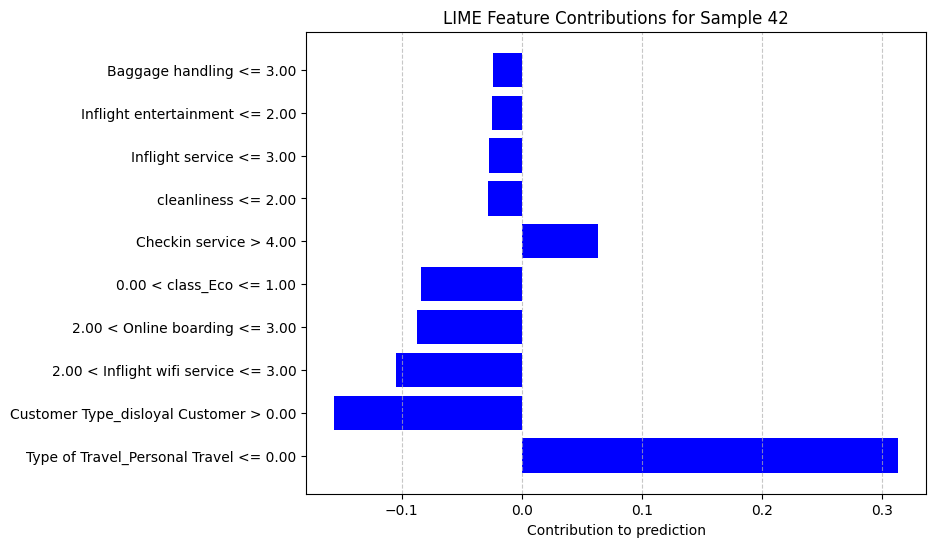

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train_one.values,
    feature_names=X_train_one.columns,
    mode="classification"
)
sample_idx = 42
sample = X_val_one.iloc[sample_idx].values

exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=rs.predict_proba
)

lime_values = exp.as_list()
features, contributions = zip(*lime_values)

plt.figure(figsize=(8, 6))
plt.barh(features, contributions, color="blue")
plt.xlabel("Contribution to prediction")
plt.title(f"LIME Feature Contributions for Sample {sample_idx}")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Самый значительный положительный вклад имеет признак Type of Travel_Personal Travel, который добавляет к итоговому предсказанию примерно 0.3. Customer Type_disloyal Customer вносит отрицательный вклад, уменьшая вероятность предсказания текущего класса примерно на 0.1



## Котобонус!

0.25 балла

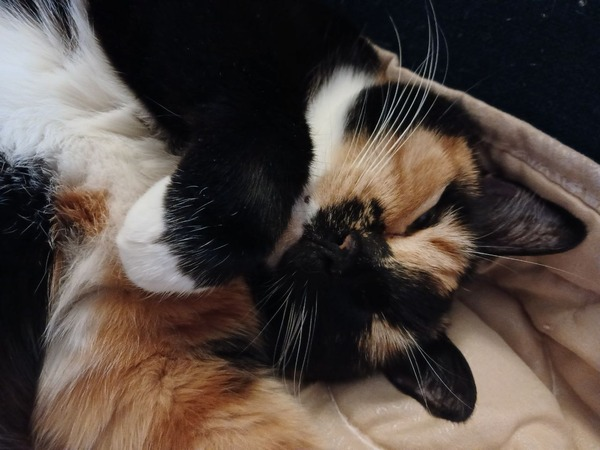

Елена

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Да, отличное домашнее задание, но довольно-таки много пришлось делать и читать дополнительно. Времени заняло - 3 дня.